### NEURAL NETWORK LIBRARY

In [1]:
import numpy as np

class Layer:
    def __init__(self):
        pass

    def forward(self, input):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        
        limit = np.sqrt(6 / (input_dim + output_dim))
        self.weights = np.random.uniform(-limit, limit, (output_dim, input_dim))
        self.biases = np.zeros(output_dim)

        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
        
    def forward(self, input):
        if input.shape[1] != self.input_dim:
            raise ValueError(f"Input dimension mismatch. Expected {self.input_dim}, got {input.shape[1]}")
        
        self.input = input  # Store for backward pass
        return np.dot(input, self.weights.T) + self.biases

    def backward(self, grad_output):
        # Ensure grad_output is 2D
        if grad_output.ndim == 1:
            grad_output = grad_output.reshape(-1, 1)

        grad_input = np.dot(grad_output, self.weights)
        self.grad_weights = np.dot(grad_output.T, self.input)
        self.grad_biases = np.sum(grad_output, axis=0)

        return grad_input
        
# Sigmoid activation layer
class Sigmoid(Layer):
    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, grad_output):
        return self.output * (1 - self.output) * grad_output
    
class ReLU(Layer):
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input

class BinaryCrossEntropy(Layer):
    def forward(self, predictions, targets):
        # Avoid division by zero
        predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
        # Calculate binary cross-entropy
        loss = -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))
        return loss

    def backward(self, predictions, targets):
        # Avoid division by zero
        predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
        # Compute gradient of loss with respect to predictions
        grad_input = (predictions - targets) / (predictions * (1 - predictions) * predictions.shape[0])
        return grad_input



class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output



def save_model(model, file_name):
    weights = {}
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            weights[f'weights_{idx}'] = layer.weights
            weights[f'biases_{idx}'] = layer.biases
    np.savez(file_name, **weights)

def load_model(model, file_name):
    data = np.load(file_name)
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            layer.weights = data[f'weights_{idx}']
            layer.biases = data[f'biases_{idx}']

## MINMAX SCALER

### PREPROCESSING 

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

# Convert 'pickup_datetime' and 'dropoff_datetime' from string to datetime objects
X_train['pickup_datetime'] = pd.to_datetime(X_train['pickup_datetime'])
X_train['dropoff_datetime'] = pd.to_datetime(X_train['dropoff_datetime'])
X_test['pickup_datetime'] = pd.to_datetime(X_test['pickup_datetime'])
X_test['dropoff_datetime'] = pd.to_datetime(X_test['dropoff_datetime'])

# Extract month, day, and hour as features
for df in [X_train, X_test]:
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['dropoff_month'] = df['dropoff_datetime'].dt.month
    df['dropoff_day'] = df['dropoff_datetime'].dt.day
    df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

# Define columns for scaling and normalize these datetime features
datetime_columns = ['pickup_month', 'pickup_day', 'pickup_hour', 'dropoff_month', 'dropoff_day', 'dropoff_hour']
scaler_datetime = MinMaxScaler()
X_train[datetime_columns] = scaler_datetime.fit_transform(X_train[datetime_columns])
X_test[datetime_columns] = scaler_datetime.transform(X_test[datetime_columns])

# Select only the required datetime columns for model input
X_train_final = X_train[datetime_columns]
X_test_final = X_test[datetime_columns]

# Split the final training data into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_final, y_train, test_size=0.2, random_state=42)

# Print the types and shapes of the final datasets to verify
print(f"Type of X_train_final: {type(X_train_final)}")
print(f"Type of X_val_final: {type(X_val_final)}")
print(f"Shape of X_train_final: {X_train_final.shape}")
print(f"Shape of X_val_final: {X_val_final.shape}")

# Print data types of the columns in X_train_final and the target variables
print(f"Data type of X_train_final: {X_train_final.dtypes}")
print(f"Data type of X_train_final: {X_test_final.dtypes}")
print(f"Data type of y_train_final: {y_train_final.dtype}")
print(f"Data type of y_val_final: {y_val_final.dtype}")

# Additional checks
print(y_train.describe())
print(X_train_final.apply(np.isfinite).all())
print(np.isfinite(y_train).all())


Type of X_train_final: <class 'pandas.core.frame.DataFrame'>
Type of X_val_final: <class 'pandas.core.frame.DataFrame'>
Shape of X_train_final: (1050223, 6)
Shape of X_val_final: (262556, 6)
Data type of X_train_final: pickup_month     float64
pickup_day       float64
pickup_hour      float64
dropoff_month    float64
dropoff_day      float64
dropoff_hour     float64
dtype: object
Data type of X_train_final: pickup_month     float64
pickup_day       float64
pickup_hour      float64
dropoff_month    float64
dropoff_day      float64
dropoff_hour     float64
dtype: object
Data type of y_train_final: int64
Data type of y_val_final: int64
count    1.312779e+06
mean     9.589538e+02
std      5.409679e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64
pickup_month     True
pickup_day       True
pickup_hour      True
dropoff_month    True
dropoff_day      True
dropoff_hour     True
dtype: bool
Tru

### MODEL SETUP

In [12]:
def build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons):
    model = Sequential()
    model.add(Linear(input_dim, layer1_neurons))
    model.add(ReLU())
    model.add(Linear(layer1_neurons, layer2_neurons))
    model.add(ReLU())
    model.add(Linear(layer2_neurons, layer3_neurons))
    model.add(ReLU())
    model.add(Linear(layer3_neurons, 1))  # Assuming regression output
    return model

### TRAINING LOOP FOR 64,32,16,LEARNING RATE=0.1,BATCH SIZE=32 CONFIGURATION

Training model with selected hyperparameters configuration
Training fold 1
Epoch 0: Train Loss = 0.7622539288984626, Validation Loss = 0.7935392953559282
Epoch 1: Train Loss = 0.7629746614880561, Validation Loss = 0.7931300083137753
Epoch 2: Train Loss = 0.7677970533278543, Validation Loss = 0.7917109223283016
Epoch 3: Train Loss = 0.7689401803848184, Validation Loss = 0.7884701055787035
Epoch 4: Train Loss = 0.7447242465808016, Validation Loss = 0.773238476792269
Epoch 5: Train Loss = 0.7245183983998201, Validation Loss = 0.7472031123087332
Epoch 6: Train Loss = 0.6532386871467557, Validation Loss = 0.7452309553457378
Epoch 7: Train Loss = 0.6363809873237055, Validation Loss = 0.7434325741916293
Epoch 8: Train Loss = 0.6356527078599907, Validation Loss = 0.7434926537433895
Epoch 9: Train Loss = 0.6356494275802179, Validation Loss = 0.7440677284524034
Epoch 10: Train Loss = 0.6295762205328578, Validation Loss = 0.7458435415325574
Stopping early at epoch 10
Training fold 2
Epoch 0: Trai

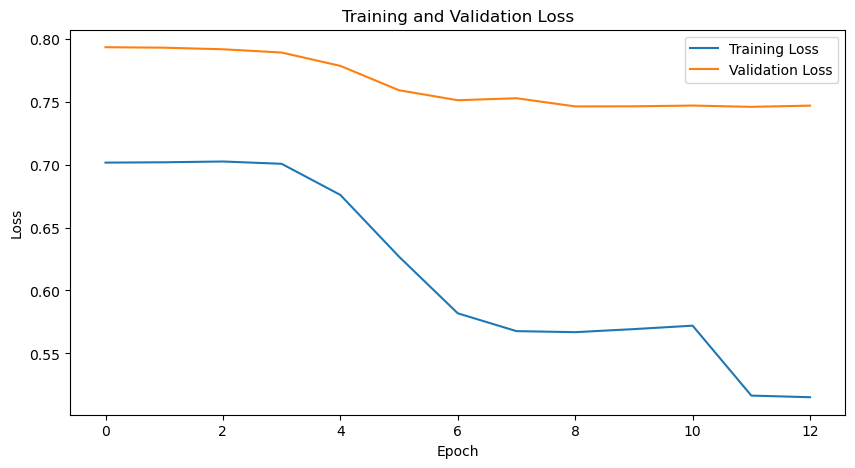

Test RMSLE: 0.7490715757267495


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the RMSLE loss function
def rmsle(predictions, targets):
    predictions = np.clip(predictions.squeeze(), a_min=1e-9, a_max=None)  # Ensure predictions are positive
    return np.sqrt(np.mean((np.log1p(predictions) - np.log1p(targets)) ** 2))

# Training function with early stopping and batch processing
def train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size):
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32)
    X_val_np = X_val.values.astype(np.float32)
    y_val_np = y_val.values.astype(np.float32)

    # Assuming build_model is defined elsewhere to construct the model
    model = build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons)

    best_loss = np.inf
    steps_since_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        for i in range(0, len(X_train_np), batch_size):
            X_batch = X_train_np[i:i+batch_size]
            y_batch = y_train_np[i:i+batch_size]

            train_predictions = model.forward(X_batch)
            train_loss = rmsle(train_predictions, y_batch)

            grad_loss = (2 / y_batch.shape[0]) * ((np.log1p(train_predictions.squeeze()) - np.log1p(y_batch)) / (1 + train_predictions.squeeze()))
            grad_loss = grad_loss.reshape(-1, 1)  # Ensure the gradient has the correct shape for backpropagation
            model.backward(grad_loss)

            for layer in model.layers:
                if hasattr(layer, 'grad_weights'):
                    layer.weights -= learning_rate * layer.grad_weights
                    layer.biases -= learning_rate * layer.grad_biases

        # Validation loss calculation after each epoch
        val_predictions = model.forward(X_val_np)
        val_loss = rmsle(val_predictions, y_val_np)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
            if steps_since_improvement >= patience:
                print(f"Stopping early at epoch {epoch}")
                break

    return model, train_losses, val_losses

# Cross-validation function
def cross_validate(X, y, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    cv_train_losses = []
    cv_val_losses = []
    models = []

    for train_index, val_index in kf.split(X):
        fold += 1
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        print(f"Training fold {fold}")

        model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size)
        models.append(model)
        cv_train_losses.append(train_losses)
        cv_val_losses.append(val_losses)

    # Pad sequences to have the same length
    max_len = max(max(len(l) for l in cv_train_losses), max(len(l) for l in cv_val_losses))
    cv_train_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_train_losses]
    cv_val_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_val_losses]

    avg_train_losses = np.nanmean(cv_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(cv_val_losses_padded, axis=0)

    return models, avg_train_losses, avg_val_losses

# Single hyperparameters configuration
model_hyperparams = {'layer1_neurons': 64, 'layer2_neurons': 32, 'layer3_neurons': 16, 'learning_rate': 0.1}
print(f"Training model with selected hyperparameters configuration")

# Assuming X_train_final and y_train_final are defined and prepared earlier in your code
models, avg_train_losses, avg_val_losses = cross_validate(X_train_final, y_train_final, input_dim=X_train_final.shape[1], **model_hyperparams, epochs=200, patience=3, batch_size=32)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Assuming save_model and load_model are defined elsewhere to handle model serialization
best_model = models[0]  # Select the first model from cross-validation folds
save_model(best_model, "model_weights_config_9.npz")

# Exclude 'learning_rate' from the parameters when calling build_model
model_hyperparams = model_hyperparams.copy()  # Copy the configuration
del model_hyperparams['learning_rate']  # Remove the learning_rate key

# To reload the model, you'll need to ensure that `build_model` and `load_model` functions are defined and work correctly.
loaded_model = build_model(input_dim=X_train_final.shape[1], **model_hyperparams)
load_model(loaded_model, "model_weights_config_9.npz")

# Convert test set to numpy arrays and correct format
X_test_np = X_test_final.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Forward pass on the test set
test_predictions = loaded_model.forward(X_test_np)

# Calculate RMSLE on the test set
test_rmsle = rmsle(test_predictions, y_test_np)
print(f"Test RMSLE: {test_rmsle}")



### TRAINING LOOP FOR 32,16,8,LEARNING RATE=0.1,BATCH SIZE=32 CONFIGURATION

Training model with selected hyperparameters configuration
Training fold 1
Epoch 0: Train Loss = 0.7623490867934429, Validation Loss = 0.7935124983154048
Epoch 1: Train Loss = 0.7629165475233863, Validation Loss = 0.7930771650154699
Epoch 2: Train Loss = 0.7662449821138306, Validation Loss = 0.791268573166402
Epoch 3: Train Loss = 0.7624637168845679, Validation Loss = 0.7853165231461292
Epoch 4: Train Loss = 0.7382649788691039, Validation Loss = 0.74997527434484
Epoch 5: Train Loss = 0.6260838169915416, Validation Loss = 0.7431544583551506
Epoch 6: Train Loss = 0.6302635220734812, Validation Loss = 0.743659338013372
Epoch 7: Train Loss = 0.6276763922826019, Validation Loss = 0.7444296464348397
Epoch 8: Train Loss = 0.6305426766605228, Validation Loss = 0.7437087670067587
Stopping early at epoch 8
Training fold 2
Epoch 0: Train Loss = 0.6075281762319328, Validation Loss = 0.7927839407807734
Epoch 1: Train Loss = 0.607349139712155, Validation Loss = 0.7925837824290611
Epoch 2: Train Loss

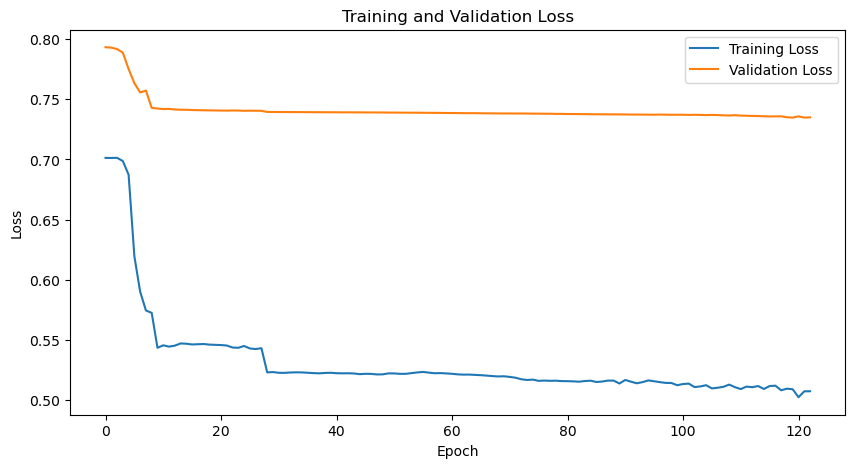

Test RMSLE: 0.7468815480585771


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the RMSLE loss function
def rmsle(predictions, targets):
    predictions = np.clip(predictions.squeeze(), a_min=1e-9, a_max=None)  # Ensure predictions are positive
    return np.sqrt(np.mean((np.log1p(predictions) - np.log1p(targets)) ** 2))

# Training function with early stopping and batch processing
def train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size):
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32)
    X_val_np = X_val.values.astype(np.float32)
    y_val_np = y_val.values.astype(np.float32)

    # Assuming build_model is defined elsewhere to construct the model
    model = build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons)

    best_loss = np.inf
    steps_since_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        for i in range(0, len(X_train_np), batch_size):
            X_batch = X_train_np[i:i+batch_size]
            y_batch = y_train_np[i:i+batch_size]

            train_predictions = model.forward(X_batch)
            train_loss = rmsle(train_predictions, y_batch)

            grad_loss = (2 / y_batch.shape[0]) * ((np.log1p(train_predictions.squeeze()) - np.log1p(y_batch)) / (1 + train_predictions.squeeze()))
            grad_loss = grad_loss.reshape(-1, 1)  # Ensure the gradient has the correct shape for backpropagation
            model.backward(grad_loss)

            for layer in model.layers:
                if hasattr(layer, 'grad_weights'):
                    layer.weights -= learning_rate * layer.grad_weights
                    layer.biases -= learning_rate * layer.grad_biases

        # Validation loss calculation after each epoch
        val_predictions = model.forward(X_val_np)
        val_loss = rmsle(val_predictions, y_val_np)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
            if steps_since_improvement >= patience:
                print(f"Stopping early at epoch {epoch}")
                break

    return model, train_losses, val_losses

# Cross-validation function
def cross_validate(X, y, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    cv_train_losses = []
    cv_val_losses = []
    models = []

    for train_index, val_index in kf.split(X):
        fold += 1
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        print(f"Training fold {fold}")

        model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size)
        models.append(model)
        cv_train_losses.append(train_losses)
        cv_val_losses.append(val_losses)

    # Pad sequences to have the same length
    max_len = max(max(len(l) for l in cv_train_losses), max(len(l) for l in cv_val_losses))
    cv_train_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_train_losses]
    cv_val_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_val_losses]

    avg_train_losses = np.nanmean(cv_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(cv_val_losses_padded, axis=0)

    return models, avg_train_losses, avg_val_losses

# Single hyperparameters configuration
model_hyperparams = {'layer1_neurons': 32, 'layer2_neurons': 16, 'layer3_neurons': 8, 'learning_rate': 0.1}
print(f"Training model with selected hyperparameters configuration")

# Assuming X_train_final and y_train_final are defined and prepared earlier in your code
models, avg_train_losses, avg_val_losses = cross_validate(X_train_final, y_train_final, input_dim=X_train_final.shape[1], **model_hyperparams, epochs=200, patience=3, batch_size=32)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Assuming save_model and load_model are defined elsewhere to handle model serialization
best_model = models[0]  # Select the first model from cross-validation folds
save_model(best_model, "model_weights_config_10.npz")

# Exclude 'learning_rate' from the parameters when calling build_model
model_hyperparams = model_hyperparams.copy()  # Copy the configuration
del model_hyperparams['learning_rate']  # Remove the learning_rate key

# To reload the model, you'll need to ensure that `build_model` and `load_model` functions are defined and work correctly.
loaded_model = build_model(input_dim=X_train_final.shape[1], **model_hyperparams)
load_model(loaded_model, "model_weights_config_10.npz")

# Convert test set to numpy arrays and correct format
X_test_np = X_test_final.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Forward pass on the test set
test_predictions = loaded_model.forward(X_test_np)

# Calculate RMSLE on the test set
test_rmsle = rmsle(test_predictions, y_test_np)
print(f"Test RMSLE: {test_rmsle}")

### TRAINING LOOP FOR 128,64,32,LEARNING RATE=0.1,BATCH SIZE=32

Training model with selected hyperparameters configuration
Training fold 1
Epoch 0: Train Loss = 0.7623587215755687, Validation Loss = 0.7935734704537939
Epoch 1: Train Loss = 0.7627943569774381, Validation Loss = 0.7932331956052131
Epoch 2: Train Loss = 0.7668231308084573, Validation Loss = 0.7919497219511865
Epoch 3: Train Loss = 0.7677371480721629, Validation Loss = 0.7882310877721675
Epoch 4: Train Loss = 0.7319017046074433, Validation Loss = 0.7625894072873705
Epoch 5: Train Loss = 0.6417613918237158, Validation Loss = 0.7438166800860738
Epoch 6: Train Loss = 0.6332845172509464, Validation Loss = 0.7477053161706947
Epoch 7: Train Loss = 0.6347411696601237, Validation Loss = 0.7441822133986858
Epoch 8: Train Loss = 0.6336107674820204, Validation Loss = 0.7440288963847431
Stopping early at epoch 8
Training fold 2
Epoch 0: Train Loss = 0.6075915963636913, Validation Loss = 0.792674446397357
Epoch 1: Train Loss = 0.6067296476307916, Validation Loss = 0.7921391035785511
Epoch 2: Train 

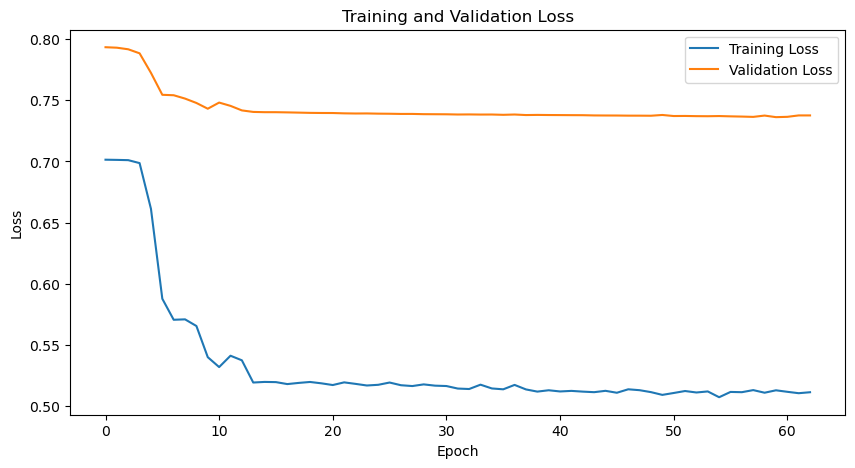

Test RMSLE: 0.7472769858630088


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the RMSLE loss function
def rmsle(predictions, targets):
    predictions = np.clip(predictions.squeeze(), a_min=1e-9, a_max=None)  # Ensure predictions are positive
    return np.sqrt(np.mean((np.log1p(predictions) - np.log1p(targets)) ** 2))

# Training function with early stopping and batch processing
def train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size):
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32)
    X_val_np = X_val.values.astype(np.float32)
    y_val_np = y_val.values.astype(np.float32)

    # Assuming build_model is defined elsewhere to construct the model
    model = build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons)

    best_loss = np.inf
    steps_since_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        for i in range(0, len(X_train_np), batch_size):
            X_batch = X_train_np[i:i+batch_size]
            y_batch = y_train_np[i:i+batch_size]

            train_predictions = model.forward(X_batch)
            train_loss = rmsle(train_predictions, y_batch)

            grad_loss = (2 / y_batch.shape[0]) * ((np.log1p(train_predictions.squeeze()) - np.log1p(y_batch)) / (1 + train_predictions.squeeze()))
            grad_loss = grad_loss.reshape(-1, 1)  # Ensure the gradient has the correct shape for backpropagation
            model.backward(grad_loss)

            for layer in model.layers:
                if hasattr(layer, 'grad_weights'):
                    layer.weights -= learning_rate * layer.grad_weights
                    layer.biases -= learning_rate * layer.grad_biases

        # Validation loss calculation after each epoch
        val_predictions = model.forward(X_val_np)
        val_loss = rmsle(val_predictions, y_val_np)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
            if steps_since_improvement >= patience:
                print(f"Stopping early at epoch {epoch}")
                break

    return model, train_losses, val_losses

# Cross-validation function
def cross_validate(X, y, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    cv_train_losses = []
    cv_val_losses = []
    models = []

    for train_index, val_index in kf.split(X):
        fold += 1
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        print(f"Training fold {fold}")

        model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size)
        models.append(model)
        cv_train_losses.append(train_losses)
        cv_val_losses.append(val_losses)

    # Pad sequences to have the same length
    max_len = max(max(len(l) for l in cv_train_losses), max(len(l) for l in cv_val_losses))
    cv_train_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_train_losses]
    cv_val_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_val_losses]

    avg_train_losses = np.nanmean(cv_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(cv_val_losses_padded, axis=0)

    return models, avg_train_losses, avg_val_losses

# Single hyperparameters configuration
model_hyperparams = {'layer1_neurons': 128, 'layer2_neurons': 64, 'layer3_neurons': 32, 'learning_rate': 0.1}
print(f"Training model with selected hyperparameters configuration")

# Assuming X_train_final and y_train_final are defined and prepared earlier in your code
models, avg_train_losses, avg_val_losses = cross_validate(X_train_final, y_train_final, input_dim=X_train_final.shape[1], **model_hyperparams, epochs=200, patience=3, batch_size=32)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Assuming save_model and load_model are defined elsewhere to handle model serialization
best_model = models[0]  # Select the first model from cross-validation folds
save_model(best_model, "model_weights_config_12.npz")

# Exclude 'learning_rate' from the parameters when calling build_model
model_hyperparams = model_hyperparams.copy()  # Copy the configuration
del model_hyperparams['learning_rate']  # Remove the learning_rate key

# To reload the model, you'll need to ensure that `build_model` and `load_model` functions are defined and work correctly.
loaded_model = build_model(input_dim=X_train_final.shape[1], **model_hyperparams)
load_model(loaded_model, "model_weights_config_12.npz")

# Convert test set to numpy arrays and correct format
X_test_np = X_test_final.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Forward pass on the test set
test_predictions = loaded_model.forward(X_test_np)

# Calculate RMSLE on the test set
test_rmsle = rmsle(test_predictions, y_test_np)
print(f"Test RMSLE: {test_rmsle}")

## STANDARD SCALER

### PREPROCESSING 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

# Convert 'pickup_datetime' and 'dropoff_datetime' from string to datetime objects
X_train['pickup_datetime'] = pd.to_datetime(X_train['pickup_datetime'])
X_train['dropoff_datetime'] = pd.to_datetime(X_train['dropoff_datetime'])
X_test['pickup_datetime'] = pd.to_datetime(X_test['pickup_datetime'])
X_test['dropoff_datetime'] = pd.to_datetime(X_test['dropoff_datetime'])

# Extract month, day, and hour as features
for df in [X_train, X_test]:
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['dropoff_month'] = df['dropoff_datetime'].dt.month
    df['dropoff_day'] = df['dropoff_datetime'].dt.day
    df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

# Define columns for scaling and normalize these datetime features
datetime_columns = ['pickup_month', 'pickup_day', 'pickup_hour', 'dropoff_month', 'dropoff_day', 'dropoff_hour']
scaler_datetime = StandardScaler()
X_train[datetime_columns] = scaler_datetime.fit_transform(X_train[datetime_columns])
X_test[datetime_columns] = scaler_datetime.transform(X_test[datetime_columns])

# Select only the required datetime columns for model input
X_train_final = X_train[datetime_columns]
X_test_final = X_test[datetime_columns]

# Log-transform the target variable
#y_train = np.log1p(y_train)
#y_test = np.log1p(y_test)

# Split the final training data into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_final, y_train, test_size=0.2, random_state=42)

# Print the types and shapes of the final datasets to verify
print(f"Type of X_train_final: {type(X_train_final)}")
print(f"Type of X_val_final: {type(X_val_final)}")
print(f"Shape of X_train_final: {X_train_final.shape}")
print(f"Shape of X_val_final: {X_val_final.shape}")

# Print data types of the columns in X_train_final and the target variables
print(f"Data type of X_train_final: {X_train_final.dtypes}")
print(f"Data type of X_train_final: {X_test_final.dtypes}")
print(f"Data type of y_train_final: {y_train_final.dtype}")
print(f"Data type of y_val_final: {y_val_final.dtype}")

# Additional checks
print(y_train.describe())
print(X_train_final.apply(np.isfinite).all())
print(np.isfinite(y_train).all())



Type of X_train_final: <class 'pandas.core.frame.DataFrame'>
Type of X_val_final: <class 'pandas.core.frame.DataFrame'>
Shape of X_train_final: (1050223, 6)
Shape of X_val_final: (262556, 6)
Data type of X_train_final: pickup_month     float64
pickup_day       float64
pickup_hour      float64
dropoff_month    float64
dropoff_day      float64
dropoff_hour     float64
dtype: object
Data type of X_train_final: pickup_month     float64
pickup_day       float64
pickup_hour      float64
dropoff_month    float64
dropoff_day      float64
dropoff_hour     float64
dtype: object
Data type of y_train_final: int64
Data type of y_val_final: int64
count    1.312779e+06
mean     9.589538e+02
std      5.409679e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64
pickup_month     True
pickup_day       True
pickup_hour      True
dropoff_month    True
dropoff_day      True
dropoff_hour     True
dtype: bool
Tru

### MODEL SETUP

In [3]:
def build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons):
    model = Sequential()
    model.add(Linear(input_dim, layer1_neurons))
    model.add(ReLU())
    model.add(Linear(layer1_neurons, layer2_neurons))
    model.add(ReLU())
    model.add(Linear(layer2_neurons, layer3_neurons))
    model.add(ReLU())
    model.add(Linear(layer3_neurons, 1))  # Regression output
    return model

### TRAINING LOOP FOR 64,32,16,LEARNING RATE=0.1,BATCH SIZE=32

Training model with selected hyperparameters configuration
Training fold 1
Epoch 0: Train Loss = 0.6388552296952308, Validation Loss = 0.7458371104590523
Epoch 1: Train Loss = 0.6310663136538359, Validation Loss = 0.7432489522419058
Epoch 2: Train Loss = 0.6352834414547286, Validation Loss = 0.741946109666047
Epoch 3: Train Loss = 0.6337347898899678, Validation Loss = 0.7414392429916219
Epoch 4: Train Loss = 0.6356969921163121, Validation Loss = 0.7413674792592828
Epoch 5: Train Loss = 0.6342815703983726, Validation Loss = 0.7412181104537947
Epoch 6: Train Loss = 0.6338295183348791, Validation Loss = 0.7418730518552609
Epoch 7: Train Loss = 0.6361947661595793, Validation Loss = 0.7407639178605527
Epoch 8: Train Loss = 0.6332212857310319, Validation Loss = 0.740741223647983
Epoch 9: Train Loss = 0.637352665797286, Validation Loss = 0.7402984893344334
Epoch 10: Train Loss = 0.634691751955349, Validation Loss = 0.7407093854421586
Epoch 11: Train Loss = 0.6349418363968455, Validation Loss 

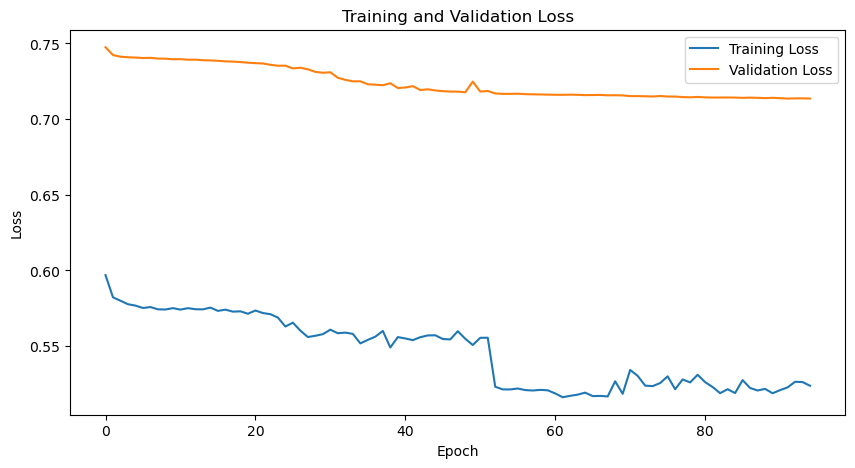

Test RMSLE: 0.7233504012133369


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the RMSLE loss function
def rmsle(predictions, targets):
    predictions = np.clip(predictions.squeeze(), a_min=1e-9, a_max=None)  # Ensure predictions are positive
    return np.sqrt(np.mean((np.log1p(predictions) - np.log1p(targets)) ** 2))

# Training function with early stopping and batch processing
def train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size):
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32)
    X_val_np = X_val.values.astype(np.float32)
    y_val_np = y_val.values.astype(np.float32)

    # Assuming build_model is defined elsewhere to construct the model
    model = build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons)

    best_loss = np.inf
    steps_since_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        for i in range(0, len(X_train_np), batch_size):
            X_batch = X_train_np[i:i+batch_size]
            y_batch = y_train_np[i:i+batch_size]

            train_predictions = model.forward(X_batch)
            train_loss = rmsle(train_predictions, y_batch)

            grad_loss = (2 / y_batch.shape[0]) * ((np.log1p(train_predictions.squeeze()) - np.log1p(y_batch)) / (1 + train_predictions.squeeze()))
            grad_loss = grad_loss.reshape(-1, 1)  # Ensure the gradient has the correct shape for backpropagation
            model.backward(grad_loss)

            for layer in model.layers:
                if hasattr(layer, 'grad_weights'):
                    layer.weights -= learning_rate * layer.grad_weights
                    layer.biases -= learning_rate * layer.grad_biases

        # Validation loss calculation after each epoch
        val_predictions = model.forward(X_val_np)
        val_loss = rmsle(val_predictions, y_val_np)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
            if steps_since_improvement >= patience:
                print(f"Stopping early at epoch {epoch}")
                break

    return model, train_losses, val_losses

# Cross-validation function
def cross_validate(X, y, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    cv_train_losses = []
    cv_val_losses = []
    models = []

    for train_index, val_index in kf.split(X):
        fold += 1
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        print(f"Training fold {fold}")

        model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size)
        models.append(model)
        cv_train_losses.append(train_losses)
        cv_val_losses.append(val_losses)

    # Pad sequences to have the same length
    max_len = max(max(len(l) for l in cv_train_losses), max(len(l) for l in cv_val_losses))
    cv_train_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_train_losses]
    cv_val_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_val_losses]

    avg_train_losses = np.nanmean(cv_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(cv_val_losses_padded, axis=0)

    return models, avg_train_losses, avg_val_losses

# Single hyperparameters configuration
model_hyperparams = {'layer1_neurons': 64, 'layer2_neurons': 32, 'layer3_neurons': 16, 'learning_rate': 0.1}
print(f"Training model with selected hyperparameters configuration")

# Assuming X_train_final and y_train_final are defined and prepared earlier in your code
models, avg_train_losses, avg_val_losses = cross_validate(X_train_final, y_train_final, input_dim=X_train_final.shape[1], **model_hyperparams, epochs=200, patience=3, batch_size=32)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Assuming save_model and load_model are defined elsewhere to handle model serialization
best_model = models[0]  # Select the first model from cross-validation folds
save_model(best_model, "model_weights_config_13.npz")

# Exclude 'learning_rate' from the parameters when calling build_model
model_hyperparams = model_hyperparams.copy()  # Copy the configuration
del model_hyperparams['learning_rate']  # Remove the learning_rate key

# To reload the model, you'll need to ensure that `build_model` and `load_model` functions are defined and work correctly.
loaded_model = build_model(input_dim=X_train_final.shape[1], **model_hyperparams)
load_model(loaded_model, "model_weights_config_13.npz")

# Convert test set to numpy arrays and correct format
X_test_np = X_test_final.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Forward pass on the test set
test_predictions = loaded_model.forward(X_test_np)

# Calculate RMSLE on the test set
test_rmsle = rmsle(test_predictions, y_test_np)
print(f"Test RMSLE: {test_rmsle}")




### TRAINING LOOP FOR 32,16,8,LEARNING RATE=0.1,BATCH SIZE=32 CONFIGURATION

Training model with selected hyperparameters configuration
Training fold 1
Epoch 0: Train Loss = 0.6404102363458084, Validation Loss = 0.7476484073578467
Epoch 1: Train Loss = 0.6303853548928923, Validation Loss = 0.7426440818780822
Epoch 2: Train Loss = 0.6328967921815376, Validation Loss = 0.7420059675803728
Epoch 3: Train Loss = 0.6356972191202853, Validation Loss = 0.7417541930888422
Epoch 4: Train Loss = 0.6372042676390819, Validation Loss = 0.741387118627704
Epoch 5: Train Loss = 0.6369293211566628, Validation Loss = 0.7411648685491938
Epoch 6: Train Loss = 0.6395000310783274, Validation Loss = 0.7411055806109539
Epoch 7: Train Loss = 0.637712597184292, Validation Loss = 0.7408296936764617
Epoch 8: Train Loss = 0.6373330766145467, Validation Loss = 0.7407475924796724
Epoch 9: Train Loss = 0.637153551488558, Validation Loss = 0.7405566186448034
Epoch 10: Train Loss = 0.6396292250941039, Validation Loss = 0.7406068536893142
Epoch 11: Train Loss = 0.6398026311909392, Validation Loss

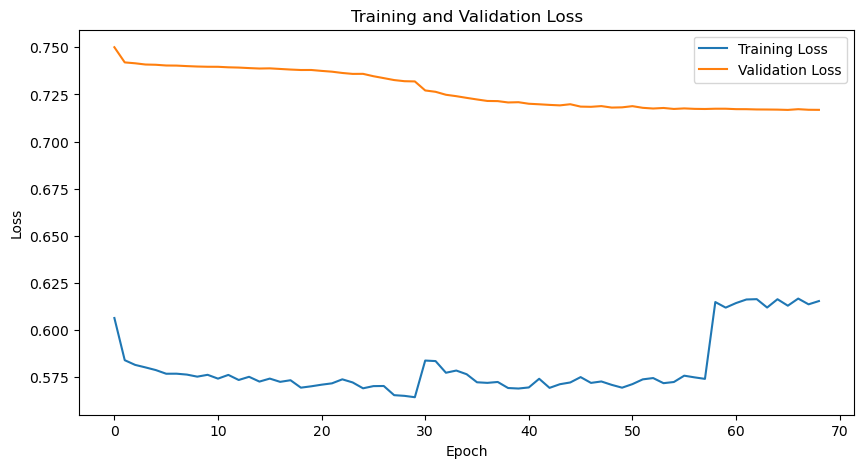

Test RMSLE: 0.7179822970938742


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the RMSLE loss function
def rmsle(predictions, targets):
    predictions = np.clip(predictions.squeeze(), a_min=1e-9, a_max=None)  # Ensure predictions are positive
    targets = np.clip(targets.squeeze(), a_min=1e-9, a_max=None)          # Ensure targets are positive
    return np.sqrt(np.mean((np.log1p(predictions) - np.log1p(targets)) ** 2))

# Training function with early stopping and batch processing
def train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size):
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32)
    X_val_np = X_val.values.astype(np.float32)
    y_val_np = y_val.values.astype(np.float32)

    # Assuming build_model is defined elsewhere to construct the model
    model = build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons)

    best_loss = np.inf
    steps_since_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        for i in range(0, len(X_train_np), batch_size):
            X_batch = X_train_np[i:i+batch_size]
            y_batch = y_train_np[i:i+batch_size]

            train_predictions = model.forward(X_batch)
            train_loss = rmsle(train_predictions, y_batch)

            grad_loss = (2 / y_batch.shape[0]) * ((np.log1p(np.clip(train_predictions.squeeze(), 1e-9, None)) - np.log1p(y_batch)) / (1 + np.clip(train_predictions.squeeze(), 1e-9, None)))
            grad_loss = grad_loss.reshape(-1, 1)  # Ensure the gradient has the correct shape for backpropagation
            model.backward(grad_loss)

            for layer in model.layers:
                if hasattr(layer, 'grad_weights'):
                    layer.weights -= learning_rate * layer.grad_weights
                    layer.biases -= learning_rate * layer.grad_biases

        # Validation loss calculation after each epoch
        val_predictions = model.forward(X_val_np)
        val_loss = rmsle(val_predictions, y_val_np)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
            if steps_since_improvement >= patience:
                print(f"Stopping early at epoch {epoch}")
                break

    return model, train_losses, val_losses

# Cross-validation function
def cross_validate(X, y, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    cv_train_losses = []
    cv_val_losses = []
    models = []

    for train_index, val_index in kf.split(X):
        fold += 1
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        print(f"Training fold {fold}")

        model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size)
        models.append(model)
        cv_train_losses.append(train_losses)
        cv_val_losses.append(val_losses)

    # Pad sequences to have the same length
    max_len = max(max(len(l) for l in cv_train_losses), max(len(l) for l in cv_val_losses))
    cv_train_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_train_losses]
    cv_val_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_val_losses]

    avg_train_losses = np.nanmean(cv_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(cv_val_losses_padded, axis=0)

    return models, avg_train_losses, avg_val_losses

# Single hyperparameters configuration
model_hyperparams = {'layer1_neurons': 32, 'layer2_neurons': 16, 'layer3_neurons': 8, 'learning_rate': 0.1}
print(f"Training model with selected hyperparameters configuration")

# Assuming X_train_final and y_train_final are defined and prepared earlier in your code
models, avg_train_losses, avg_val_losses = cross_validate(X_train_final, y_train_final, input_dim=X_train_final.shape[1], **model_hyperparams, epochs=200, patience=3, batch_size=32)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Assuming save_model and load_model are defined elsewhere to handle model serialization
best_model = models[0]  # Select the first model from cross-validation folds
save_model(best_model, "model_weights_config_14.npz")

# Exclude 'learning_rate' from the parameters when calling build_model
model_hyperparams = model_hyperparams.copy()  # Copy the configuration
del model_hyperparams['learning_rate']  # Remove the learning_rate key

# To reload the model, you'll need to ensure that `build_model` and `load_model` functions are defined and work correctly.
loaded_model = build_model(input_dim=X_train_final.shape[1], **model_hyperparams)
load_model(loaded_model, "model_weights_config_14.npz")

# Convert test set to numpy arrays and correct format
X_test_np = X_test_final.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Forward pass on the test set
test_predictions = loaded_model.forward(X_test_np)

# Calculate RMSLE on the test set
test_rmsle = rmsle(test_predictions, y_test_np)
print(f"Test RMSLE: {test_rmsle}")


### TRAINING LOOP FOR 128,64,32,LEARNING RATE=0.1,BATCH SIZE=32 CONFIGURATION

Training model with selected hyperparameters configuration
Training fold 1
Epoch 0: Train Loss = 0.6467154213721241, Validation Loss = 0.7492702443789409
Epoch 1: Train Loss = 0.6286359880607314, Validation Loss = 0.7429786469092686
Epoch 2: Train Loss = 0.6323570878856694, Validation Loss = 0.7421471554012774
Epoch 3: Train Loss = 0.6328715977761451, Validation Loss = 0.7416702814115707
Epoch 4: Train Loss = 0.6324247805334999, Validation Loss = 0.741227280631199
Epoch 5: Train Loss = 0.6366391112869889, Validation Loss = 0.7409972301031952
Epoch 6: Train Loss = 0.6360140604870198, Validation Loss = 0.7408778154847665
Epoch 7: Train Loss = 0.6366821216587518, Validation Loss = 0.7407024738442145
Epoch 8: Train Loss = 0.6361404441403191, Validation Loss = 0.7403305090102004
Epoch 9: Train Loss = 0.633816833715716, Validation Loss = 0.7403685501454447
Epoch 10: Train Loss = 0.6326843279056573, Validation Loss = 0.7400670675061467
Epoch 11: Train Loss = 0.6334618509268575, Validation Los

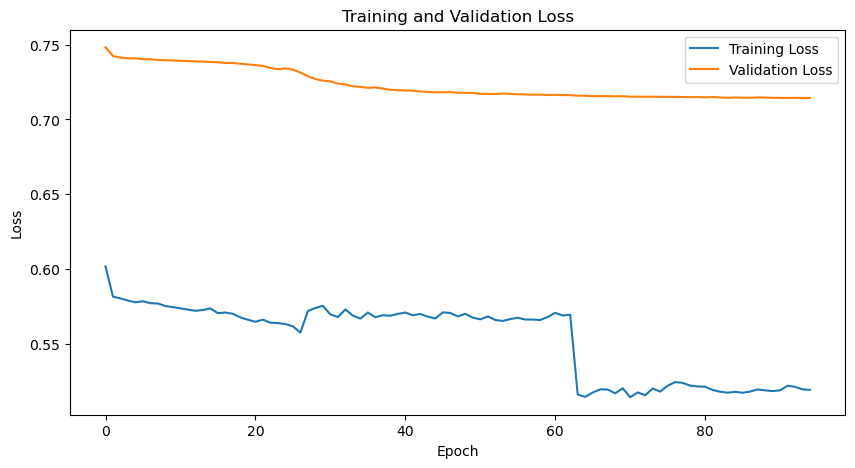

Test RMSLE: 0.7177436226296388


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define the RMSLE loss function
def rmsle(predictions, targets):
    predictions = np.clip(predictions.squeeze(), a_min=1e-9, a_max=None)  # Ensure predictions are positive
    targets = np.clip(targets.squeeze(), a_min=1e-9, a_max=None)          # Ensure targets are positive
    return np.sqrt(np.mean((np.log1p(predictions) - np.log1p(targets)) ** 2))

# Training function with early stopping and batch processing
def train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size):
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32)
    X_val_np = X_val.values.astype(np.float32)
    y_val_np = y_val.values.astype(np.float32)

    # Assuming build_model is defined elsewhere to construct the model
    model = build_model(input_dim, layer1_neurons, layer2_neurons, layer3_neurons)

    best_loss = np.inf
    steps_since_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        for i in range(0, len(X_train_np), batch_size):
            X_batch = X_train_np[i:i+batch_size]
            y_batch = y_train_np[i:i+batch_size]

            train_predictions = model.forward(X_batch)
            train_loss = rmsle(train_predictions, y_batch)

            grad_loss = (2 / y_batch.shape[0]) * ((np.log1p(np.clip(train_predictions.squeeze(), 1e-9, None)) - np.log1p(y_batch)) / (1 + np.clip(train_predictions.squeeze(), 1e-9, None)))
            grad_loss = grad_loss.reshape(-1, 1)  # Ensure the gradient has the correct shape for backpropagation
            model.backward(grad_loss)

            for layer in model.layers:
                if hasattr(layer, 'grad_weights'):
                    layer.weights -= learning_rate * layer.grad_weights
                    layer.biases -= learning_rate * layer.grad_biases

        # Validation loss calculation after each epoch
        val_predictions = model.forward(X_val_np)
        val_loss = rmsle(val_predictions, y_val_np)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
            if steps_since_improvement >= patience:
                print(f"Stopping early at epoch {epoch}")
                break

    return model, train_losses, val_losses

# Cross-validation function
def cross_validate(X, y, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    cv_train_losses = []
    cv_val_losses = []
    models = []

    for train_index, val_index in kf.split(X):
        fold += 1
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        print(f"Training fold {fold}")

        model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, input_dim, layer1_neurons, layer2_neurons, layer3_neurons, learning_rate, epochs, patience, batch_size)
        models.append(model)
        cv_train_losses.append(train_losses)
        cv_val_losses.append(val_losses)

    # Pad sequences to have the same length
    max_len = max(max(len(l) for l in cv_train_losses), max(len(l) for l in cv_val_losses))
    cv_train_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_train_losses]
    cv_val_losses_padded = [np.pad(l, (0, max_len - len(l)), constant_values=np.nan) for l in cv_val_losses]

    avg_train_losses = np.nanmean(cv_train_losses_padded, axis=0)
    avg_val_losses = np.nanmean(cv_val_losses_padded, axis=0)

    return models, avg_train_losses, avg_val_losses

# Single hyperparameters configuration
model_hyperparams = {'layer1_neurons': 128, 'layer2_neurons': 64, 'layer3_neurons': 36, 'learning_rate': 0.1}
print(f"Training model with selected hyperparameters configuration")

# Assuming X_train_final and y_train_final are defined and prepared earlier in your code
models, avg_train_losses, avg_val_losses = cross_validate(X_train_final, y_train_final, input_dim=X_train_final.shape[1], **model_hyperparams, epochs=200, patience=3, batch_size=32)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Assuming save_model and load_model are defined elsewhere to handle model serialization
best_model = models[0]  # Select the first model from cross-validation folds
save_model(best_model, "model_weights_config_15.npz")

# Exclude 'learning_rate' from the parameters when calling build_model
model_hyperparams = model_hyperparams.copy()  # Copy the configuration
del model_hyperparams['learning_rate']  # Remove the learning_rate key

# To reload the model, you'll need to ensure that `build_model` and `load_model` functions are defined and work correctly.
loaded_model = build_model(input_dim=X_train_final.shape[1], **model_hyperparams)
load_model(loaded_model, "model_weights_config_15.npz")

# Convert test set to numpy arrays and correct format
X_test_np = X_test_final.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Forward pass on the test set
test_predictions = loaded_model.forward(X_test_np)

# Calculate RMSLE on the test set
test_rmsle = rmsle(test_predictions, y_test_np)
print(f"Test RMSLE: {test_rmsle}")
